In [1]:
import mne
import os
import matplotlib.pyplot as plt

In [2]:
RAW_DATA = "/dhc/cold/groups/metrics/data/raw"
SETS = ["dev", "eval", "train"]
CONFIGURATIONS = ["01_tcp_ar", "02_tcp_le", "03_tcp_ar_a", "04_tcp_le_a"]


In [3]:
def get_patients(set_name): 
    path = os.path.join(RAW_DATA, "edf", set_name)
    patients = [f.path for f in os.scandir(path) if f.is_dir()]
    return patients


def get_sessions(patient):
    sessions = [f.path for f in os.scandir(patient) if f.is_dir()]
    return sessions


def get_configurations(session):
    configurations = [f.path for f in os.scandir(session) if f.is_dir()]
    return configurations


def get_recordings(configuration):
    recordings = [f.path for f in os.scandir(configuration) if f.is_file() and f.name.endswith(".edf")]
    return recordings


def get_recording_annotation(recording):
    annotation_file = recording.replace(".edf", ".csv_bi") 
    return annotation_file

In [4]:
def get_sessions_with_multiple_configurations(patients):
    sessions_with_multiple_configurations = []
    for patient in patients:
        sessions = get_sessions(patient)
        for session in sessions:
            configurations = get_configurations(session)
            if len(configurations) > 1:
                sessions_with_multiple_configurations.append(session)
        
    return sessions_with_multiple_configurations


patients = get_patients("eval")
get_sessions_with_multiple_configurations(patients)

[]

In [5]:
def filter_sessions_by_configurations(patients, configurations):
    filtered_sessions = []
    for patient in patients:
        sessions = get_sessions(patient)
        for session in sessions:
            session_configuration = get_configurations(session)[0].split("/")[-1]
            if session_configuration in configurations:
                filtered_sessions.append(session)

    return filtered_sessions

In [6]:
def parse_annotation(annotation):
    with open(annotation, "r") as f:
        lines = f.readlines()
        duration = float(lines[2].split(" ")[3])
        events = lines[6:]

        segments = []

        prev_end = float(0)
        for event in events:
            event = event.split(",")
            start = float(event[1])
            end = float(event[2])
            seizure = event[3] == "seiz"
            
            if seizure:
                if start > prev_end:
                    segments.append((prev_end, start, False))
                
                segments.append((start, end, True))
                prev_end = end
        
        if prev_end < duration:
            segments.append((prev_end, duration, False))
            
        return segments

session = get_sessions(patients[0])[0]
configuration = get_configurations(session)[0]
recording = get_recordings(configuration)[4]
parse_annotation(get_recording_annotation(recording))

[(0.0, 300.0, False)]

In [7]:
def resample_data(raw, sampling_rate):
    if raw.info["sfreq"] != sampling_rate:
        print(f"Resampling data from {raw.info['sfreq']} Hz to {sampling_rate} Hz")
        raw.resample(sampling_rate)

    return raw

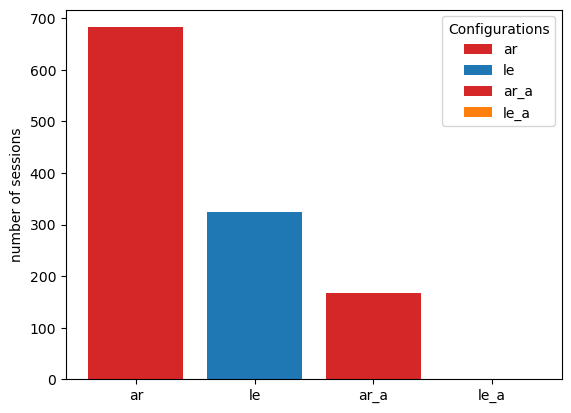

In [8]:

patients = get_patients("train")
ar_sessions = filter_sessions_by_configurations(patients, ["01_tcp_ar"])
le_sessions = filter_sessions_by_configurations(patients, ["02_tcp_le"])
ar_a_sessions = filter_sessions_by_configurations(patients, ["03_tcp_ar_a"])
le_a_sessions = filter_sessions_by_configurations(patients, ["04_tcp_le_a"])

fig, ax = plt.subplots()

configurations = ['ar', 'le', 'ar_a', 'le_a']
counts = [len(ar_sessions), len(le_sessions), len(ar_a_sessions), len(le_a_sessions)]
bar_labels = ['ar', 'le', 'ar_a', 'le_a']
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

ax.bar(configurations, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('number of sessions')
ax.legend(title='Configurations')

plt.show()

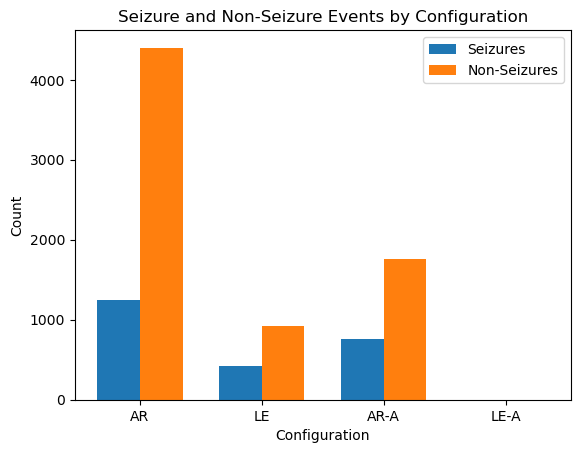

In [9]:
ar_seizures, ar_non_seizures = 0, 0
le_seizures, le_non_seizures = 0, 0
ar_a_seizures, ar_a_non_seizures = 0, 0
le_a_seizures, le_a_non_seizures = 0, 0

for session in ar_sessions:
    recordings = get_recordings(get_configurations(session)[0])
    for recording in recordings:
        annotation = get_recording_annotation(recording)
        segments = parse_annotation(annotation)
        ar_seizures += len([segment for segment in segments if segment[2]])
        ar_non_seizures += len([segment for segment in segments if not segment[2]])
        
    
for session in le_sessions:
    recordings = get_recordings(get_configurations(session)[0])
    for recording in recordings:
        annotation = get_recording_annotation(recording)
        segments = parse_annotation(annotation)
        le_seizures += len([segment for segment in segments if segment[2]])
        le_non_seizures += len([segment for segment in segments if not segment[2]])
                           

for session in ar_a_sessions:
    recordings = get_recordings(get_configurations(session)[0])
    for recording in recordings:
        annotation = get_recording_annotation(recording)
        segments = parse_annotation(annotation)
        ar_a_seizures += len([segment for segment in segments if segment[2]])
        ar_a_non_seizures += len([segment for segment in segments if not segment[2]])
        

for session in le_a_sessions:
    recordings = get_recordings(get_configurations(session)[0])
    for recording in recordings:
        annotation = get_recording_annotation(recording)
        segments = parse_annotation(annotation)
        le_a_seizures += len([segment for segment in segments if segment[2]])
        le_a_non_seizures += len([segment for segment in segments if not segment[2]])


# Data for plotting
configurations = ['AR', 'LE', 'AR-A', 'LE-A']
seizures = [ar_seizures, le_seizures, ar_a_seizures, le_a_seizures]
non_seizures = [ar_non_seizures, le_non_seizures, ar_a_non_seizures, le_a_non_seizures]

# Plotting
x = range(len(configurations))

fig, ax = plt.subplots()

# Plot bars
bar_width = 0.35
ax.bar(x, seizures, bar_width, label='Seizures')
ax.bar([p + bar_width for p in x], non_seizures, bar_width, label='Non-Seizures')

# Labeling
ax.set_xlabel('Configuration')
ax.set_ylabel('Count')
ax.set_title('Seizure and Non-Seizure Events by Configuration')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(configurations)
ax.legend()

plt.show()

In [ ]:
seizure_samples = []
non_seizure_samples = []

for ar_session in ar_sessions[:5]:
    configuration = get_configurations(ar_session)[0]
    recordings = get_recordings(configuration)    

    for recording in recordings:
        annotation_file = get_recording_annotation(recording)
        segments = parse_annotation(annotation_file)

        raw = mne.io.read_raw_edf(recording, preload=True)
        raw_resampled = resample_data(raw, 256) 
        tmax = raw_resampled.times[-1]

        for segment in segments:
            start = segment[0]
            end = min(tmax, segment[1])
            seizure = segment[2]
            if seizure:
                seizure_samples.append(raw_resampled.copy().crop(start, end))
            else:
                non_seizure_samples.append(raw_resampled.copy().crop(start, end))

        print(annotation_file)
        break


seizure_samples
%matplotlib inline
non_seizure_samples[0].plot()

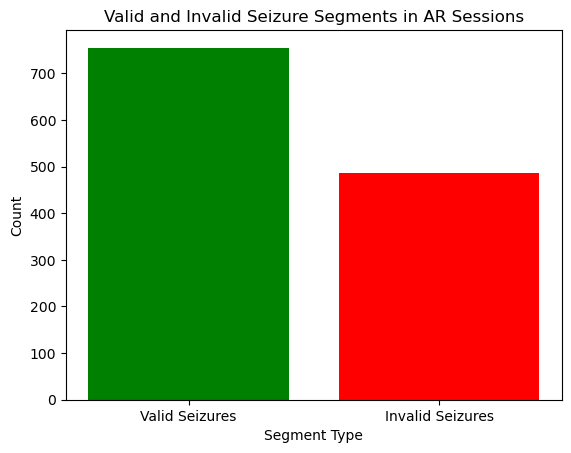

In [10]:
# Check if seizure segments are followed by non-seizure of at least the same length
def check_segments(segments):
    valid_segments = []
    invalid_segments = []
    
    for i, segment in enumerate(segments):
        seizure = segment[2]
        if seizure:
            if i + 1 < len(segments):
                next_segment = segments[i + 1]
                next_segment_is_seizure = next_segment[2]
                if not next_segment_is_seizure:
                    if next_segment[1] - next_segment[0] >= segment[1] - segment[0]:
                        valid_segments.append(segment)
                    else:
                        invalid_segments.append(segment)
                else:
                    invalid_segments.append(segment)
            else:
                invalid_segments.append(segment)

    return valid_segments, invalid_segments

valid_seizure_segments, invalid_seizure_segments = 0, 0
for session in ar_sessions:
    recordings = get_recordings(get_configurations(session)[0])
    for recording in recordings:
        annotation = get_recording_annotation(recording)
        segments = parse_annotation(annotation)
        valid, invalid = check_segments(segments)
        valid_seizure_segments += len(valid)
        invalid_seizure_segments += len(invalid)

# Plotting
labels = ['Valid Seizures', 'Invalid Seizures']
counts = [valid_seizure_segments, invalid_seizure_segments]

fig, ax = plt.subplots()

ax.bar(labels, counts, color=['green', 'red'])
ax.set_xlabel('Segment Type')
ax.set_ylabel('Count')
ax.set_title('Valid and Invalid Seizure Segments in AR Sessions')

plt.show()


In [23]:
def calc_session_length(session):
    configuration = get_configurations(session)[0]
    recordings = get_recordings(configuration)
    length = 0

    for recording in recordings:
        annotation = get_recording_annotation(recording)
        
        with open(annotation, "r") as file:
            lines = file.readlines()
            length += len(lines)
            
    return length

calc_session_length(sessions[0])
    

8

In [20]:
class Recording:
    path = ""
    configuration = ""
    annotation = ""
    segments = []
      
    # type must be AR, LE, AR-A, or LE-A
    def __init__(self, path, configuration):
        self.path = path
        self.configuration = configuration
        self.annotation = get_recording_annotation(path)
        self.segments = parse_annotation(self.annotation)

    def __parse_annotation(annotation_file):
        segments = []
        with open(annotation, "r") as f:
            lines = f.readlines()
            duration = float(lines[2].split(" ")[3])
            events = lines[6:]

            segments = []

            prev_end = float(0)
            for event in events:
                event = event.split(",")
                start = float(event[1])
                end = float(event[2])
                seizure = event[3] == "seiz"
                
                if seizure:
                    if start > prev_end:
                        segments.append((prev_end, start, False))
                    
                    segments.append((start, end, True))
                    prev_end = end
            
            if prev_end < duration:
                segments.append((prev_end, duration, False))

        return segments

rec1 = Recording(get_recordings(get_configurations(ar_sessions[0])[0])[0], "AR")
rec1.configuration


'AR'

In [ ]:
class Session:
    recordings = []
    configuration = ""
    
    def __init__(self, path):
        